<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/predictive_maintanence_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from array import array
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import math
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
from math import sqrt
from matplotlib import pyplot

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
df = pd.read_excel("/content/drive/MyDrive/Datasets/predictive maintance /AnalizDataPM.xlsx",engine='openpyxl')
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S
df=df.groupby("Time").mean()
df.reset_index(inplace=True)
df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df.head()

,Time,vibx,vibz,temp,zacc,crest,zfreq
0,2020-01-17 00:00:00,1.208404,0.968665,29.501891,0.260534,3.817392,0.070044
1,2020-01-17 01:00:00,1.173835,1.045636,29.352279,0.262390,3.857893,0.069983
2,2020-01-17 02:00:00,1.161203,0.959516,29.187751,0.259026,3.811876,0.069978
3,2020-01-17 03:00:00,1.191830,0.957197,29.630256,0.260562,3.833699,0.070006
4,2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902


# Arima

In [12]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.5MB 7.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [13]:
pickle_in = open('/content/drive/MyDrive/model_predictive_maintanence/temp_arima.pkl', 'rb')
temp_arima_model = pickle.load(pickle_in)
pickle_in = open('/content/drive/MyDrive/model_predictive_maintanence/vibx_arima.pkl', 'rb')
vibx_arima_model = pickle.load(pickle_in)
pickle_in = open('/content/drive/MyDrive/model_predictive_maintanence/vibz_arima.pkl', 'rb')
vibz_arima_model = pickle.load(pickle_in)
pickle_in = open('/content/drive/MyDrive/model_predictive_maintanence/zacc_arima.pkl', 'rb')
zacc_arima_model = pickle.load(pickle_in)
pickle_in = open('/content/drive/MyDrive/model_predictive_maintanence/crest_arima.pkl', 'rb')
crest_arima_model = pickle.load(pickle_in)
pickle_in = open('/content/drive/MyDrive/model_predictive_maintanence/zfreq_arima.pkl', 'rb')
zfreq_arima_model = pickle.load(pickle_in)

In [29]:
df_arima = pd.DataFrame()
arima_models= [vibx_arima_model,vibz_arima_model,temp_arima_model,zacc_arima_model,crest_arima_model,zfreq_arima_model]
columns=["vibx","vibz","temp","zacc","crest","zfreq"]
for model,col in zip(arima_models,columns):
    df_arima['arima_predicted_'+col]=model.predict(start=df.index[0],end=df.index[-1])
    df_arima[col]=df[col]


TypeError: ignored

In [23]:
df_arima.head()

""


# LSTM univariate prediction

In [112]:
# convert an array of values into a dataset matrix
df_lstm_univarete = pd.DataFrame()
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [119]:
 def test_lstm_univariate(df,col):
    pickle_in = open(f"/content/drive/MyDrive/model_predictive_maintanence/{col}_scaler_lstm_univarate.pkl", 'rb')
    scaler_lstm_univarate = pickle.load(pickle_in)
    df1=scaler_lstm_univarate.transform(np.array(df.loc[:,col]).reshape(-1,1))
    model_lstm_univarate=load_model(f"/content/drive/MyDrive/model_predictive_maintanence/{col}_lstm_univariate_model.h5")
    X_test, ytest = create_dataset(df1, time_step=3)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    test_predict=model_lstm_univarate.predict(X_test)
    test_predict=scaler_lstm_univarate.inverse_transform(test_predict)
    return test_predict

In [120]:
test_lstm_predict={}
for col in df.columns[1:7]:
  test_lstm_predict[col]=test_lstm_univariate(df,col)


In [121]:
for col in df.columns[1:7]:
  df_lstm_univarete[col+"lstm_predicted"]= [float(i) for i in test_lstm_predict[col]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'v' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'b' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'x' instances.
A proxy artist may be used instead.
Se

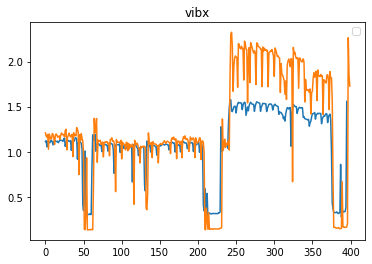

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'z' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """


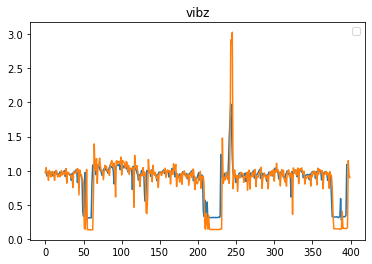

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'e' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'm' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
Se

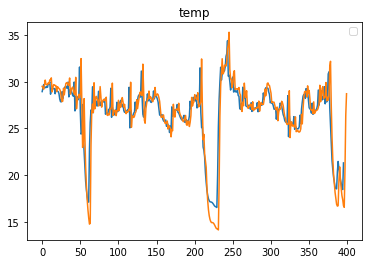

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'c' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """


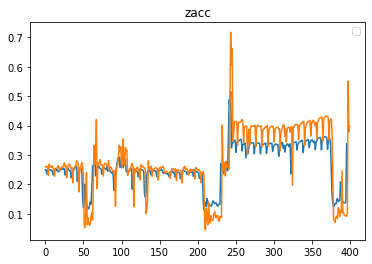

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 's' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """


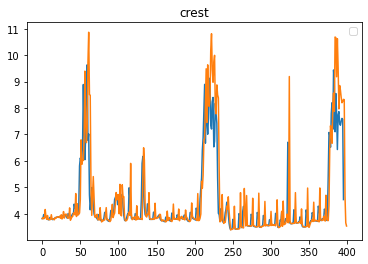

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'q' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """


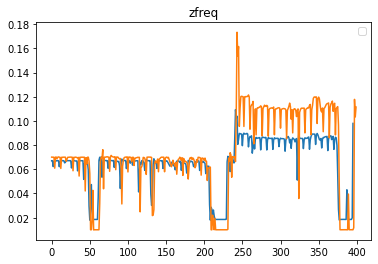

In [125]:
for col in df.columns[1:]:
  plt.plot(df_lstm_univarete[col+"lstm_predicted"])
  plt.plot(df[col])
  plt.title(col)
  plt.legend(col+"pred",col)
  plt.show()

# Lstm multivariate

In [5]:
data=df.copy()

In [6]:
fail_time =df[df["Time"]=="2020-01-27 14:00:00"].index[0]

In [7]:
df['Hour'] = df['Time'].apply(lambda time: time.hour)
df['Month'] = df['Time'].apply(lambda time: time.month)
df['Day of Week'] = df['Time'].apply(lambda time: time.dayofweek)
df['Year'] = df['Time'].apply(lambda t: t.year)
df=pd.get_dummies(df,columns=['Hour','Month','Day of Week','Year'],drop_first=True)



In [8]:
for col in df.columns[1:7]:
  for i in range(1,4):
      df['lag_'+str(i)+col] = df[col].shift(i)
for col in df.columns[1:7]:
  df[col+'expanding_mean'] = df[col].expanding(5).mean()
  df[col+'expanding_std'] = df[col].expanding(5).std()
df.dropna(axis=0,inplace=True)

In [9]:
df_columns=['Time', 'vibx', 'vibz', 'temp', 'zacc', 'crest', 'zfreq', 'Hour_1',
       'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8',
       'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14',
       'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20',
       'Hour_21', 'Hour_22', 'Hour_23', 'Month_2', 'Day of Week_1',
       'Day of Week_2', 'Day of Week_3', 'Day of Week_4', 'Day of Week_5',
       'Day of Week_6', 'lag_1vibx', 'lag_2vibx', 'lag_3vibx', 'lag_1vibz',
       'lag_2vibz', 'lag_3vibz', 'lag_1temp', 'lag_2temp', 'lag_3temp',
       'lag_1zacc', 'lag_2zacc', 'lag_3zacc', 'lag_1crest', 'lag_2crest',
       'lag_3crest', 'lag_1zfreq', 'lag_2zfreq', 'lag_3zfreq',
       'vibxexpanding_mean', 'vibxexpanding_std', 'vibzexpanding_mean',
       'vibzexpanding_std', 'tempexpanding_mean', 'tempexpanding_std',
       'zaccexpanding_mean', 'zaccexpanding_std', 'crestexpanding_mean',
       'crestexpanding_std', 'zfreqexpanding_mean', 'zfreqexpanding_std']

In [12]:
for col in df_columns:
  if col not in df.columns:
    df[col]=[0 for i in df.index]

In [49]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
df_lstm_multivariate={}

In [56]:
def lstm_multivariate(df,col_num):
  
  values = df.iloc[:,1:].values

  # ensure all data is float
  values = values.astype('float32')
  # normalize features


  pickle_in = open(f"/content/drive/MyDrive/model_predictive_maintanence/{df.columns[col_num+1]}_scaler_lstm_multivariate.pkl", 'rb')
  scaler_lstm_multivariate = pickle.load(pickle_in)
  scaled = scaler_lstm_multivariate.transform(values)
  # specify the number of lag hours
  n_hours = 10
  n_features = df.iloc[:,1:].shape[1]
  # frame as supervised learning
  reframed = series_to_supervised(scaled, n_hours, 1)
  #print(reframed.shape)
      
  # split into train and test sets
  values = reframed.values
  n_train_hours = fail_time-96
      
  test = values
  # split into input and outputs
  n_obs = n_hours * n_features
      
  test_X, test_y = test[:, :n_obs], test[:, col_num]
  #print(train_X.shape, len(train_X), train_y.shape)
  # reshape input to be 3D [samples, timesteps, features]
  test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
  # design network
  # make a prediction
  model_lstm_multivariate=load_model(f"/content/drive/MyDrive/model_predictive_maintanence/{df.columns[col_num+1]}multivariateLSTM_model.h5")
  yhat = model_lstm_multivariate.predict(test_X)
  test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
  # invert scaling for forecast
  inv_yhat1 = np.repeat(yhat, df.shape[1]-1, axis=-1)
  inv_yhat1 = scaler_lstm_multivariate.inverse_transform(inv_yhat1)
  inv_yhat1 = inv_yhat1[:,0]
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = np.repeat(test_y, df.shape[1]-1, axis=-1)
  inv_y = scaler_lstm_multivariate.inverse_transform(inv_y)
  inv_y = inv_y[:,0]
  
  # calculate RMSE
  rmse = sqrt(mean_squared_error(inv_y, inv_yhat1))
  print('Test RMSE: %.3f' % rmse)
  pyplot.figure(figsize=(12, 8), dpi=80)
  pyplot.plot(inv_y,label=df.columns[col_num+1])
  pyplot.plot(inv_yhat1,label=df.columns[col_num+1]+"_predicted")
  pyplot.title(df.columns[col_num+1]+" multivariate LSTM")
  pyplot.legend()
  pyplot.show()
  return inv_yhat1

Test RMSE: 0.574


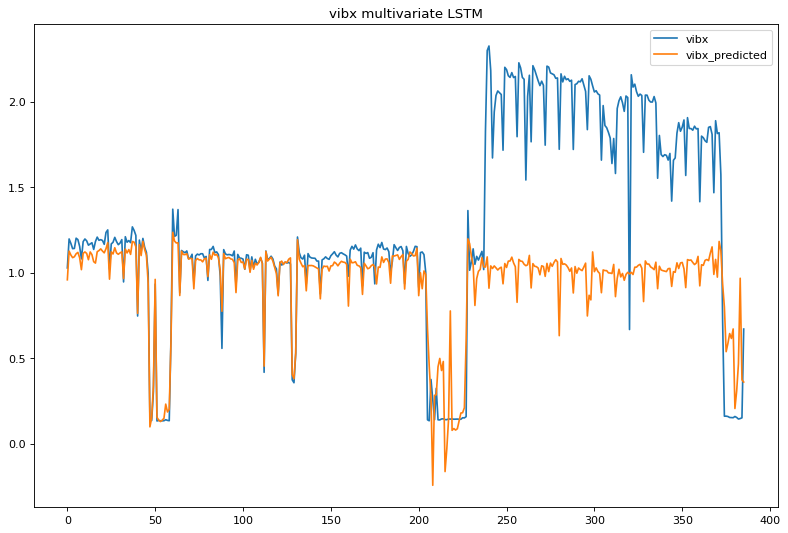

Test RMSE: 0.167


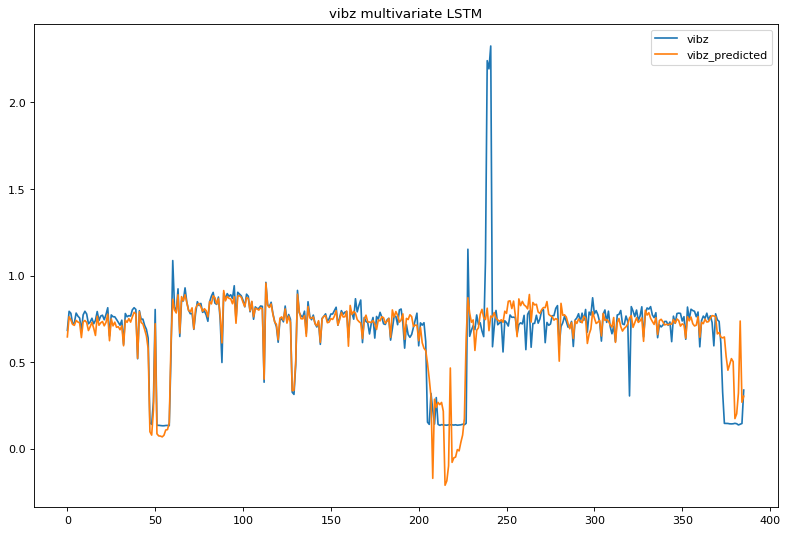

Test RMSE: 0.234


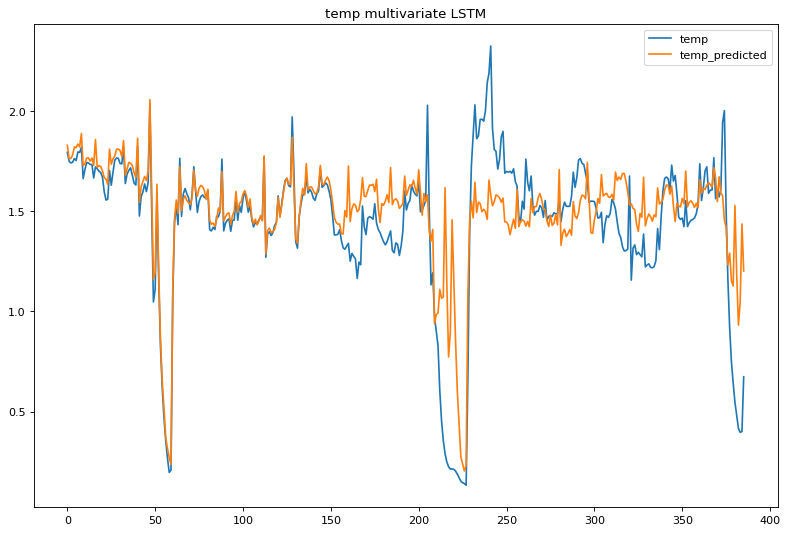

Test RMSE: 0.329


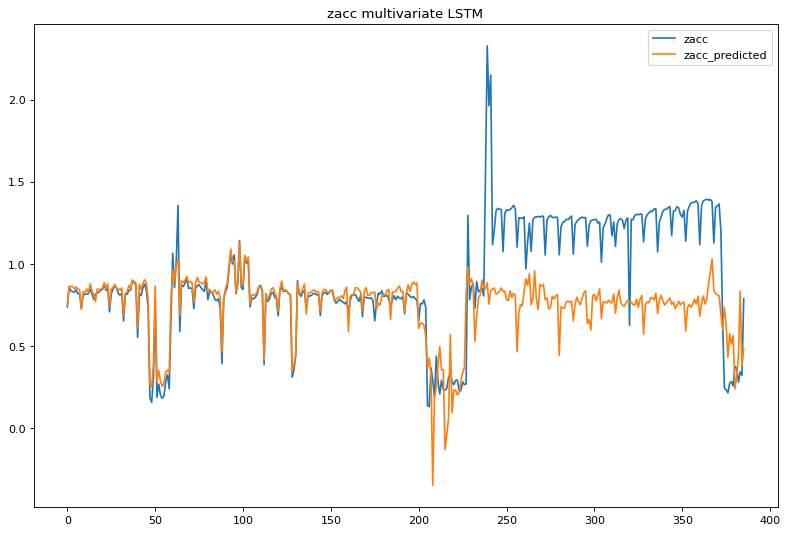

Test RMSE: 0.250


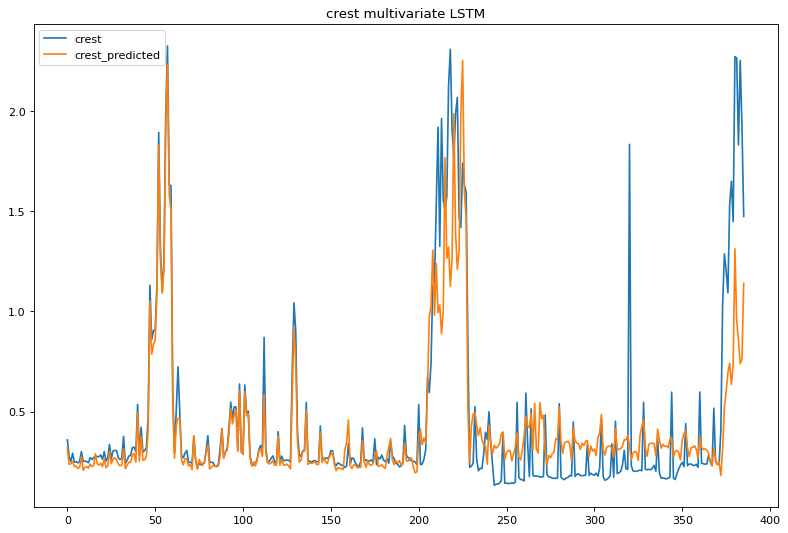

Test RMSE: 0.393


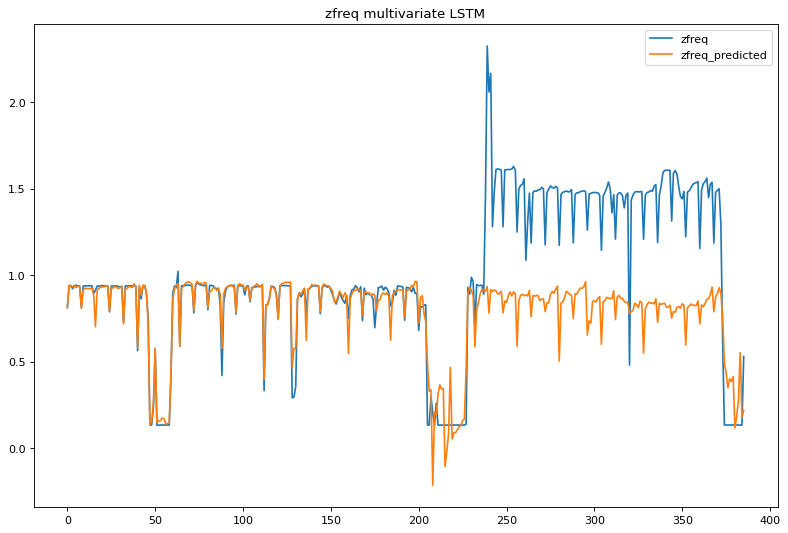

In [65]:
test_lstm_multivariate_predict_df=pd.DataFrame()
for i in range(0,6):
    test_lstm_multivariate_predict_df[df.columns[i+1]]=lstm_multivariate(df=df,col_num=i)


In [66]:
test_lstm_multivariate_predict_df

,vibx,vibz,temp,zacc,crest,zfreq
0,0.957972,0.645476,1.829894,0.750227,0.318392,0.810717
1,1.125625,0.761514,1.763468,0.859571,0.236661,0.941491
2,1.103021,0.743666,1.764104,0.863873,0.239481,0.936817
3,1.087458,0.717659,1.780899,0.863063,0.251227,0.933213
4,1.092649,0.712034,1.821757,0.848720,0.225594,0.940998
...,...,...,...,...,...,...
381,0.307913,0.201252,1.187113,0.315947,0.953394,0.183459
382,0.466354,0.321136,0.931764,0.433493,0.860553,0.273641
383,0.966915,0.737076,1.048194,0.835560,0.738702,0.552368
384,0.372641,0.267925,1.437065,0.382109,0.763459,0.179437
